## Developing the RF Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score

sns.set()
plt.rcParams["figure.figsize"] = (10, 8)
SEED = 42

train_ = pd.read_csv("assets/train.csv")
test_ = pd.read_csv("assets/test.csv")

train = train_.copy()
test = test_.copy()

In [2]:
num_features = set([c for c in train.columns if train[c].dtype != "object"])
cat_features = set([c for c in train.columns if c not in num_features])
print("Numerical Features: {}\nCategorical Features: {}".format(num_features, cat_features))

Numerical Features: {'SibSp', 'Survived', 'Fare', 'Age', 'PassengerId', 'Pclass', 'Parch'}
Categorical Features: {'Sex', 'Ticket', 'Embarked', 'Cabin', 'Name'}


## Pre-Processing

#### Dealing with Missing Values

In [3]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

**Age**

Age is missing for 263 passengers. Let's replace the missing values with the mean age for now. This could be an area to come back to since age is one of the more important features in the dataset.

In [5]:
train["Age"].mean(), test["Age"].median()

(29.69911764705882, 27.0)

In [6]:
for df in [train, test]:
    df["Age"].fillna(df["Age"].mean(), inplace=True)

**Embarked**

Only 2 passengers are missing the Embarked feature. One option would be to replace with the mode:

In [7]:
train["Embarked"].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

Observe that both passengers missing Embarked data were in Pclass 1. Let's look at the Embarked value counts for Pclass 1:

In [8]:
train[train["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [9]:
train[train["Pclass"] == 1]["Embarked"].value_counts(normalize=True)

S    0.593458
C    0.397196
Q    0.009346
Name: Embarked, dtype: float64

Since the mode of Embarked for Pclass 1 is the same as the mode for the entire dataset, let's go ahead and replace the missing values with S.

In [10]:
for df in [train, test]:
    df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

**Fare**

Only one passenger is missing Fare. Let's replace with this missing value with the mean.

In [11]:
train["Fare"].mean(), test["Fare"].median()

(32.2042079685746, 14.4542)

In [12]:
for df in [train, test]:
    df["Fare"].fillna(df["Fare"].mean(), inplace=True)

**Cabin**

1014 passengers are missing Cabin. We will deal with this later when we process categorical features.

## Feature Engineering

#### Numerical Features

In [13]:
train.describe() # numerical features only

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I have chosen to add two additional numerical features:

* FamilySize = SibSp + Parch
* AgeClass = Age x Pclass

These features are common in many notebooks that I have read on this challenge.

In [15]:
for df in [train, test]:
    family_size = df["SibSp"] + df["Parch"]
    df["FamilySize"] = family_size
    
    age_class = df["Age"] * df["Pclass"]
    df["AgeClass"] = age_class

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,AgeClass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,66.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,78.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,105.0


## Train Model - Numerical Only + Added Features

Let's see how well the model does using numerical features only.

In [16]:
X = train.copy().drop(columns=cat_features)
y = X.pop("Survived")

rf = RandomForestClassifier(n_estimators=1000, random_state=SEED)
rf.fit(X, y)
cv_results = cross_validate(rf, X, y, cv=5, return_train_score=True) # returns a dict of arrays containing the scores/times

In [17]:
print("Train Score: {}\nTest Score: {}\nFit Time: {}\nTest Stdev * 3: {}\n".format(
    cv_results["train_score"].mean(), 
    cv_results["test_score"].mean(), 
    cv_results["fit_time"].mean(), 
    cv_results["test_score"].std()*3))

Train Score: 1.0
Test Score: 0.692690228020769
Fit Time: 0.7485455513000489
Test Stdev * 3: 0.19056624113161183



In [18]:
yhat = rf.predict(test.drop(columns=cat_features))
yhat[0:5]

array([0, 0, 0, 1, 0], dtype=int64)

In [19]:
preds = cross_val_predict(rf, X, y, cv=5)
roc_auc_score(y, preds)

0.6633592177164221

#### Categorical Variables

**Name**

The name field contains valuable information in the form of each person's title, for example: Mr or Miss. Let's extract those titles and look at the frequency count.

In [20]:
train["Name"].str.split(', ', expand=True).head()

,0,1
0,Braund,Mr. Owen Harris
1,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss. Laina
3,Futrelle,Mrs. Jacques Heath (Lily May Peel)
4,Allen,Mr. William Henry


In [21]:
train_titles = train["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0].value_counts().to_frame().rename(columns={0: "Train"})
train_titles

,Train
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Major,2
Col,2
Capt,1


In [22]:
test_titles = test["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0].value_counts().to_frame().rename(columns={0: "Test"})
test_titles

,Test
Mr,240
Miss,78
Mrs,72
Master,21
Col,2
Rev,2
Dr,1
Dona,1
Ms,1


How many times does each title appear in the training and test sets?

In [23]:
title_counts = pd.concat([train_titles, test_titles], axis=1, sort=True).fillna(0)
title_counts["Total"] = title_counts.sum(axis=1)
title_counts.sort_values(by="Total", ascending=False, inplace=True)
title_counts[["Train", "Test", "Total"]] = title_counts[["Train", "Test", "Total"]].astype("int")
title_counts

,Train,Test,Total
Mr,517,240,757
Miss,182,78,260
Mrs,125,72,197
Master,40,21,61
Rev,6,2,8
Dr,7,1,8
Col,2,2,4
Ms,1,1,2
Major,2,0,2
Mlle,2,0,2


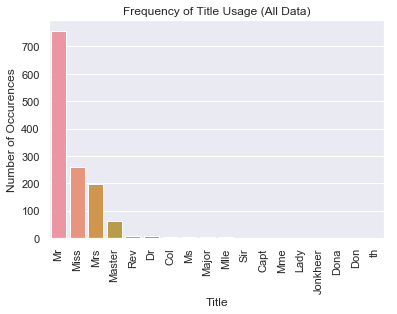

In [24]:
sns.barplot(data=title_counts.reset_index(), x="index", y="Total")
plt.xlabel("Title")
plt.xticks(rotation=90)
plt.ylabel("Number of Occurences")
plt.title("Frequency of Title Usage (All Data)")
plt.show()

Determine which titles are unique so that we can make sure to group them into a more general category:

In [25]:
title_counts.loc[(title_counts["Total"] <= 1), :]

,Train,Test,Total
Sir,1,0,1
Capt,1,0,1
Mme,1,0,1
Lady,1,0,1
Jonkheer,1,0,1
Dona,0,1,1
Don,1,0,1
th,1,0,1


In [26]:
test.loc[test["Name"].str.contains("Dona")]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,AgeClass
239,1131,1,"Douglas, Mrs. Walter Donald (Mahala Dutton)",female,48.0,1,0,PC 17761,106.425,C86,C,1,48.0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900,C105,C,0,39.0


Below is a function that will group rare titles into more common categories.

In [27]:
def replace_rare_titles(df):
    title = df["Title"]
    if title in ["Capt", "Col", "Don", "Jonkheer", "Major", "Sir", "Rev"]:
        return "Mr"
    elif title in ["Mme", "th", "Lady", "Dona"]:
        return 'Mrs'
    elif title in ["Mlle", "Ms"]:
        return 'Miss'
    elif title =='Dr':
        if df['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

**Cabin**

Likewise, the cabin field also contains useful information: the first letter from the Cabin field represents the deck.

In [28]:
def list_decks():
    cabins = train["Cabin"].value_counts().index
    
    temp = []
    for c in cabins:
        for i in c:
            if i.isalpha():
                temp.append(i)

    return np.unique(temp)

In [29]:
cabin_list = np.append(list_decks(),"Unknown")
cabin_list

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Unknown'], dtype='<U7')

In [30]:
def substrings_in_string(big_string, substrings):
    if pd.isna(big_string):
        return "Unknown"
    for substring in substrings:
        if big_string.find(substring) != -1:
            if substring == "T":
                return "A"
            else:
                return substring

Putting it all together, I'll extract the title and deck and apply one-hot-encoding to the categorical columns.

In [31]:
def engineer_categorical_features(df):
    temp = df.copy()
    
    titles = temp["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0]
    temp["Title"] = titles
    temp["Title"] = temp.apply(replace_rare_titles, axis=1)
    
    deck = temp["Cabin"].map(lambda x: substrings_in_string(x, cabin_list))
    temp["Deck"] = deck

    one_hot_cols = ["Embarked", "Title", "Deck", "Sex"]
    
    for o in one_hot_cols:
        dummies = pd.get_dummies(temp[o], prefix=o)
        temp = pd.concat([temp, dummies], axis=1)
    temp.drop(columns=list(cat_features) + ["Title", "Deck", "Embarked", "Sex"], inplace=True)
    
    return temp

train = engineer_categorical_features(train)
test = engineer_categorical_features(test)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,AgeClass,Embarked_C,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_Unknown,Sex_female,Sex_male
0,1,0,3,22.0,1,0,7.2500,1,66.0,0,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,38.0,1,0,71.2833,1,38.0,1,...,0,0,1,0,0,0,0,0,1,0
2,3,1,3,26.0,0,0,7.9250,0,78.0,0,...,0,0,0,0,0,0,0,1,1,0
3,4,1,1,35.0,1,0,53.1000,1,35.0,0,...,0,0,1,0,0,0,0,0,1,0
4,5,0,3,35.0,0,0,8.0500,0,105.0,0,...,0,0,0,0,0,0,0,1,0,1


## Double Check Cleaned Data

In [32]:
train.isnull().sum().sum(), test.isnull().sum().sum() # confirm no missing values

(0, 0)

In [33]:
X = train.copy()
y = X.pop("Survived")

In [34]:
X.shape, test.shape

((891, 25), (418, 25))

In [35]:
X.columns, test.columns, set(X.columns) - set(test.columns)

(Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
        'AgeClass', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master',
        'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C',
        'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_Unknown', 'Sex_female',
        'Sex_male'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
        'AgeClass', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master',
        'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C',
        'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_Unknown', 'Sex_female',
        'Sex_male'],
       dtype='object'),
 set())

In [36]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [37]:
def train_score_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    yhat = model.predict(X_val)
    
    roc = roc_auc_score(y_val, yhat) #receiver operating characteristic curve
    accuracy_train = model.score(X_train, y_train) #r2 on training data
    accuracy_val = model.score(X_val, y_val) #r2 on validation data
    
    return roc, accuracy_train, accuracy_val

## Train Model - All Features

In [38]:
rf = RandomForestClassifier(n_estimators=1000, random_state=SEED)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [39]:
cv_results = cross_validate(rf, X, y, cv=5, return_train_score=True) # returns a dict of arrays containing the scores/times
print("Train Score: {}\nTest Score: {}\nFit Time: {}\nTest Stdev * 3: {}\n".format(
    cv_results["train_score"].mean(), 
    cv_results["test_score"].mean(), 
    cv_results["fit_time"].mean(), 
    cv_results["test_score"].std()*3))

Train Score: 1.0
Test Score: 0.812652657807132
Fit Time: 0.7558474063873291
Test Stdev * 3: 0.07982627347467225



In [40]:
yhat = rf.predict(test)
yhat[0:5]

array([0, 0, 0, 1, 1], dtype=int64)

In [41]:
preds = cross_val_predict(rf, X, y, cv=5)
roc_auc_score(y, preds)

0.7894736842105263

### Generate Submission

In [42]:
def generate_submission(filename, yhat, save=False):
    submission_df = pd.DataFrame(columns=["PassengerId", "Survived"])
    submission_df["PassengerId"] = test["PassengerId"]
    submission_df["Survived"] = yhat
    if save:
        submission_df.to_csv("submissions/"+filename, header=True, index=False)
    return submission_df

filename = "test.csv"
submission = generate_submission(filename, yhat, False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


## Testing

In [43]:
def engineer_numerical_features(df):
    temp = df.copy()
    
    # temp["Age"].fillna(temp["Age"].mean(), inplace=True)
    mean = temp["Age"].mean()
    std = temp["Age"].std()
    is_null = temp["Age"].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size=is_null)
    ages = temp["Age"].copy()
    ages[np.isnan(ages)] = rand_age
    temp["Age"] = ages
    temp["Age"] = temp["Age"].astype(int)

    temp.loc[temp["Age"] <= 18, "Age"] = 0
    temp.loc[(temp["Age"] > 18) & (temp["Age"] <= 23), "Age"] = 1
    temp.loc[(temp["Age"] > 23) & (temp["Age"] <= 28), "Age"] = 2
    temp.loc[(temp["Age"] > 28) & (temp["Age"] <= 34), "Age"] = 3
    temp.loc[(temp["Age"] > 34) & (temp["Age"] <= 44), "Age"] = 4
    temp.loc[(temp["Age"] > 44), "Age"] = 5

    #temp["Fare"].fillna(0, inplace=True)
    mean = temp["Fare"].mean()
    std = temp["Fare"].std()
    is_null = temp["Fare"].isnull().sum()
    rand_fare = np.random.randint(mean - std, mean + std, size=is_null)
    fares = temp["Fare"].copy()
    fares[np.isnan(fares)] = rand_fare
    temp["Fare"] = fares
    
    # Need to fix this binning:

    temp.loc[ temp["Fare"] <= 7.775, "Fare"] = 0
    temp.loc[(temp["Fare"] > 7.775) & (temp["Fare"] <= 8.662), "Fare"] = 1
    temp.loc[(temp["Fare"] > 8.662) & (temp["Fare"] <= 14.454), "Fare"] = 2
    temp.loc[(temp["Fare"] > 14.454) & (temp["Fare"] <= 26), "Fare"] = 3
    temp.loc[(temp["Fare"] > 26) & (temp["Fare"] <= 52.369), "Fare"] = 4
    temp.loc[ temp["Fare"] > 52.369, "Fare"] = 5
    temp["Fare"] = temp["Fare"].astype(int)
    
    family_size = temp["SibSp"] + temp["Parch"]
    temp["FamilySize"] = family_size
    
    fare_per_person = temp["Fare"] / (temp["FamilySize"] + 1)
    temp["FarePerPerson"] = fare_per_person
    
    age_class = temp["Age"] * temp["Pclass"]
    temp["AgeClass"] = age_class
    
    return temp

In [44]:
a = pd.qcut(train_["Fare"], q=6)
a.value_counts()

(-0.001, 7.775]      156
(7.775, 8.662]       152
(52.369, 512.329]    149
(14.454, 26.0]       149
(26.0, 52.369]       146
(8.662, 14.454]      139
Name: Fare, dtype: int64

In [45]:
a = pd.qcut(train_["Age"], q=6)
a.value_counts()

(0.419, 18.0]    139
(34.0, 44.0]     121
(28.0, 34.0]     116
(23.0, 28.0]     116
(44.0, 80.0]     115
(18.0, 23.0]     107
Name: Age, dtype: int64

In [46]:
def engineer_categorical_features(df):
    temp = df.copy()
    
    temp["Embarked"].fillna(temp["Embarked"].mode()[0], inplace=True)
    
    titles = temp["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0]
    temp["Title"] = titles
    temp["Title"] = temp.apply(replace_rare_titles, axis=1)
    
    #deck = temp["Cabin"].map(lambda x: substrings_in_string(x, cabin_list))
    temp["Cabin"] = temp["Cabin"].fillna("U0")
    deck = temp["Cabin"].map(lambda x: x[0])
    temp["Deck"] = deck
    decks = {"A": 1, "T": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
    temp["Deck"] = temp["Deck"].map(decks)
    temp["Deck"] = temp["Deck"].astype(int)
    
#     genders = {"male": 0, "female": 1}
#     temp["Sex"] = temp["Sex"].map(genders)
    
#     ports = {"S": 0, "C": 1, "Q": 2}
#     temp["Embarked"] = temp["Embarked"].map(ports)
    
    one_hot_cols = ["Title", "Sex", "Embarked"]
    
    for o in one_hot_cols:
        dummies = pd.get_dummies(temp[o], prefix=o)
        temp = pd.concat([temp, dummies], axis=1)
    
    temp.drop(columns=list(cat_features) + ["Title", "Sex", "Embarked", "PassengerId"], inplace=True)
    
    return temp

In [47]:
train_z = engineer_numerical_features(train_)
test_z = engineer_numerical_features(test_)

In [48]:
train_z = engineer_categorical_features(train_z)
test_z = engineer_categorical_features(test_z)

In [49]:
train_z["Fare"].value_counts(normalize=True)

3    0.175084
0    0.175084
5    0.167228
4    0.163861
2    0.162738
1    0.156004
Name: Fare, dtype: float64

In [50]:
train_z["Age"].value_counts().sort_index()

0    163
1    137
2    153
3    152
4    171
5    115
Name: Age, dtype: int64

In [51]:
train_z.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
       'FarePerPerson', 'AgeClass', 'Deck', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [52]:
X = train_z.copy()
y = X.pop("Survived")
rf = RandomForestClassifier(n_estimators=1000, random_state=SEED)
rf.fit(X, y)
#scores = cross_val_score(rf, X, y, cv=5)
#scores.mean()
cv_results = cross_validate(rf, X, y, cv=5, return_train_score=True) # returns a dict of arrays containing the scores/times
print("Train Score: {}\nTest Score: {}\nFit Time: {}\nTest Stdev * 3: {}\n".format(
    cv_results["train_score"].mean(), 
    cv_results["test_score"].mean(), 
    cv_results["fit_time"].mean(), 
    cv_results["test_score"].std()*3))

Train Score: 0.9304193549711359
Test Score: 0.7947064441392204
Fit Time: 0.6728673934936523
Test Stdev * 3: 0.07290108604988293



Train Score: 0.9135858976649267
Test Score: 0.8059739973267485
Fit Time: 0.2469468593597412
Test Stdev * 3: 0.11198147675167908

Train Score: 0.9149888161766748
Test Score: 0.8093699630504008
Fit Time: 0.2429518699645996
Test Stdev * 3: 0.12686837358381609

Train Score: 0.917516510993196
Test Score: 0.8082338134050551
Fit Time: 0.24993019104003905
Test Stdev * 3: 0.12041522118372955

In [53]:
preds = cross_val_predict(rf, X, y, cv=5)
roc_auc_score(y, preds)

0.7749017352123478

In [54]:
yhat = rf.predict(test_z)
yhat[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [55]:
importances = pd.DataFrame(rf.feature_importances_, index=X.columns.values, columns=["Importance"]).sort_values(by="Importance")
importances

,Importance
Embarked_Q,0.011403
Title_Master,0.013336
Embarked_C,0.018840
Embarked_S,0.020972
Parch,0.025194
Title_Miss,0.026110
Title_Mrs,0.027835
SibSp,0.039756
FamilySize,0.052048
Fare,0.063813


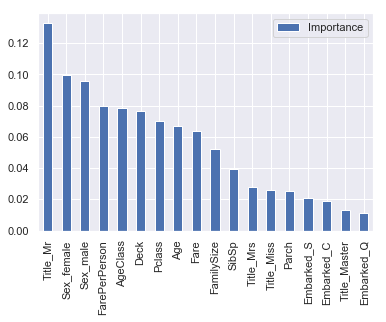

In [56]:
importances.sort_values(by="Importance", ascending=False).plot(kind="bar")

## Optimizing the Model

In [57]:
# n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# random_grid = {"n_estimators": n_estimators}

# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, random_state=SEED)

# rf_random.fit(X, y)

In [58]:
#rf_random.best_params_

{'n_estimators': 400}

### Test Output

In [59]:
filename = "random_forest_feat_eng_7.csv"
submission = generate_submission(filename, yhat, False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


**Resources**

* https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial
* https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy